In [2]:
import os
import wave
import numpy as np

folder_path = "Crema"  # Specify the folder path

# Get a list of all .wav files in the folder
wav_files = [file for file in os.listdir(folder_path) if file.endswith(".wav")]

# Create an empty array to store the audio data
audio_data_array = []

# Loop through each .wav file and read its contents
for file in wav_files:
    file_path = os.path.join(folder_path, file)  # Construct the full file path

    # Open the .wav file
    with wave.open(file_path, "rb") as wav_file:
        # Read the audio data from the .wav file
        audio_data = wav_file.readframes(wav_file.getnframes())
        
        # Convert the audio data to a NumPy array
        audio_data_np = np.frombuffer(audio_data, dtype=np.int16)
        
        # Append the audio data array to the main array
        audio_data_array.append(audio_data_np)

# Convert the array to a NumPy array for easier manipulation (optional)
audio_data_array = np.array(audio_data_array)

# Print the shape of the audio data array
print(f"Shape of audio data array: {audio_data_array.shape}")


Shape of audio data array: (7442,)


C:\Users\usefw\AppData\Local\Temp\ipykernel_9076\968331460.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  audio_data_array = np.array(audio_data_array)


In [3]:
audio_data_array = np.array(audio_data_array)

for i in range(len(audio_data_array)):
    padding_columns = 80080 - len(audio_data_array[i])
    audio_data_array[i] = np.array(audio_data_array[i])
    padded_row = np.pad(audio_data_array[i], (0, 80080 - len(audio_data_array[i]) ), mode='constant')
    audio_data_array[i] = padded_row


In [4]:
import os

folder_path = 'Crema'  # Path to the folder 'Crema'

# Get the list of file names in the folder
file_names = os.listdir(folder_path)

y=[]
for file_name in file_names:
    y.append(file_name.split('_')[2])



In [5]:
y_float = np.zeros((7442, 1), dtype=float)

for i in range(len(y)):
    if y[i] == 'ANG':
        y_float[i]=0
    elif y[i] == 'DIS':
        y_float[i]=1
    elif y[i] == 'FEA':
        y_float[i]=2
    elif y[i] == 'HAP':
        y_float[i]=3
    elif y[i] == 'NEU':
        y_float[i]=4
    elif y[i] == 'SAD':
        y_float[i]=5


In [6]:
def calculate_energy(signal, total_outputs):
    frame_size = len(signal) // total_outputs  # Adjust frame size based on desired outputs
    energy = []
    
    for i in range(0, len(signal), frame_size):
        frame = signal[i:i+frame_size]
        frame_energy = np.sum(frame**2)  # Calculate energy of frame
        energy.append(frame_energy)
    
    return energy

import numpy as np

def calculate_zcr(signal, total_outputs):
    signal_length = len(signal)
    frame_size = signal_length // total_outputs
    
    zcr = np.zeros(total_outputs)
    
    for i in range(total_outputs):
        start = i * frame_size
        end = start + frame_size
        
        frame = signal[start:end]
        crossings = np.sum(np.diff(np.sign(frame)) != 0)
        zcr[i] = crossings / frame_size
    
    return zcr




In [113]:
numfeatures = 500
zcr_matrix = np.empty((0, numfeatures)) 
for i in range(len(audio_data_array)):
    x= calculate_zcr(audio_data_array[i], numfeatures)
    zcr_matrix = np.vstack((zcr_matrix, x))
print(zcr_matrix.shape)

(7442, 500)


In [114]:
#drop last column of energy matrix
print(zcr_matrix.shape)

(7442, 500)


In [115]:
#split data into train and test and validation sets with 70%, 25%, 5% with stratify
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(zcr_matrix, y_float, test_size=0.3, random_state=42, stratify=y_float)
#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1667, random_state=42, stratify=y_test)
X_train_rest, X_val, y_train_rest, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, stratify=y_train)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(5209, 500)
(261, 500)
(2233, 500)


In [123]:
import tensorflow as tf

# Create the CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(numfeatures, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5, strides=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(numfeatures, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(numfeatures, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(numfeatures, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(numfeatures, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=6, activation='softmax'))
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00039)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20)
#evaluate validation set
loss, accuracy = model.evaluate(X_val, y_val)
predictions = model.predict(X_val)
print("Loss:", loss)
print("Accuracy:", accuracy)



# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


# Calculate the F1 score
from sklearn.metrics import f1_score
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
f1score = f1_score(y_test, y_pred, average='weighted')
print('F1 Score:', f1score)


Epoch 1/20
163/163 [==============================] - 11s 57ms/step - loss: 1.7523 - accuracy: 0.2384
Epoch 2/20
163/163 [==============================] - 9s 56ms/step - loss: 1.5907 - accuracy: 0.3431
Epoch 3/20
163/163 [==============================] - 10s 58ms/step - loss: 1.5566 - accuracy: 0.3611
Epoch 4/20
163/163 [==============================] - 11s 65ms/step - loss: 1.5181 - accuracy: 0.3813
Epoch 5/20
163/163 [==============================] - 10s 63ms/step - loss: 1.4873 - accuracy: 0.3989
Epoch 6/20
163/163 [==============================] - 10s 63ms/step - loss: 1.4723 - accuracy: 0.4053
Epoch 7/20
163/163 [==============================] - 10s 63ms/step - loss: 1.4620 - accuracy: 0.4087
Epoch 8/20
163/163 [==============================] - 10s 64ms/step - loss: 1.4263 - accuracy: 0.4250
Epoch 9/20
163/163 [==============================] - 10s 63ms/step - loss: 1.4212 - accuracy: 0.4225
Epoch 10/20
163/163 [==============================] - 10s 64ms/step - loss: 1.4043

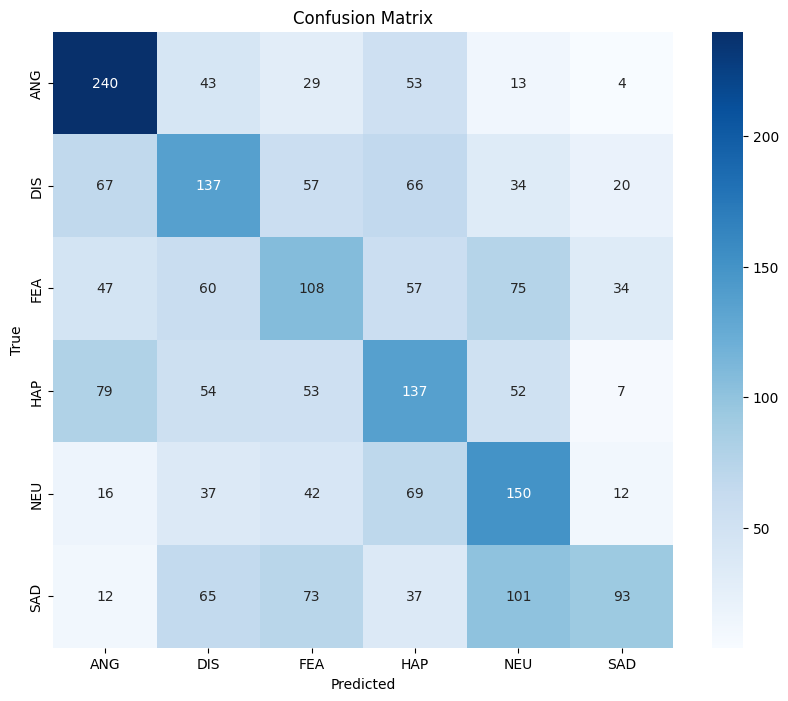

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have predictions and true labels stored in 'y_pred' and 'y_true' variables

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels (if applicable)
class_labels = ['ANG', 'DIS', 'FEA','HAP','NEU','SAD']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()
